In [ ]:
!pip install transformers datasets scikit-learn torch --quiet

In [ ]:
# --- Imports ---
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import classification_report
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset
import torch
import numpy as np
import pandas as pd



In [ ]:
# -------------------- DATA LOADING --------------------
df = pd.read_csv('/content/hate_sample_for_finetune.csv')

In [ ]:
df = df.dropna(subset=['hate_type_teacher'])



In [ ]:
# --------------------------
import re
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "URL", text)
    text = re.sub(r"@\w+", "@user", text)
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # keep spaces
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['clean_text_fixed'] = df['text'].apply(clean_text)

In [ ]:
# Map text labels to integers
label_mapping = {label: idx for idx, label in enumerate(df['hate_type_teacher'].unique())}
df['hate_type_teacher_int'] = df['hate_type_teacher'].map(label_mapping)
print("Label mapping:", label_mapping)

Label mapping: {'political framing hate': 0, 'sarcasm-based hate': 1, 'meme-language hate': 2, 'humor-based hate': 3, 'metaphor-based hate': 4}


In [ ]:
# --- Model and Tokenizer ---
model_name = "cardiffnlp/twitter-roberta-large-hate-latest"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_mapping), ignore_mismatched_sizes=True)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-large-hate-latest and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([8]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([8, 1024]) in the checkpoint and torch.Size([5, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# --- Data Splitting ---
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'],
    df['hate_type_teacher_int'],
    test_size=0.2, # 20% for validation
    random_state=42,
    stratify=df['hate_type_teacher_int'] # Stratify to maintain class distribution
)



In [ ]:
# --- Tokenization ---
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=256)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=256)



In [ ]:
# --- Custom Dataset ---
class HateDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_dataset = HateDataset(train_encodings, list(train_labels))
val_dataset = HateDataset(val_encodings, list(val_labels))


In [ ]:
# --- Compute Class Weights (for balancing rare labels) ---
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float)



In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    logging_dir="./logs",
    load_best_model_at_end=True
)

In [ ]:
# --- Custom Trainer (to apply class weights) ---
from torch.nn import CrossEntropyLoss

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=0):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = CrossEntropyLoss(weight=class_weights.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [ ]:
# --- Trainer ---
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)





/tmp/ipython-input-2365696059.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


In [ ]:
# --- Train Model ---
trainer.train()



Epoch,Training Loss,Validation Loss
1,No log,1.257516
2,No log,1.028205
3,1.191200,1.175120
4,1.191200,1.126920


TrainOutput(global_step=796, training_loss=0.9383920449108335, metrics={'train_runtime': 1290.7149, 'train_samples_per_second': 4.928, 'train_steps_per_second': 0.617, 'total_flos': 2963571774935040.0, 'train_loss': 0.9383920449108335, 'epoch': 4.0})

In [ ]:
# --- Evaluation ---
predictions = trainer.predict(val_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = val_labels

print(" Accuracy:", np.mean(y_pred == y_true))
print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(label_mapping.keys())))

 Accuracy: 0.6557788944723618

 Classification Report:
                        precision    recall  f1-score   support

political framing hate       0.63      0.77      0.69        22
    sarcasm-based hate       0.87      0.72      0.79       254
    meme-language hate       0.45      0.56      0.50        36
      humor-based hate       0.26      0.38      0.31        24
   metaphor-based hate       0.39      0.52      0.44        62

              accuracy                           0.66       398
             macro avg       0.52      0.59      0.55       398
          weighted avg       0.71      0.66      0.67       398



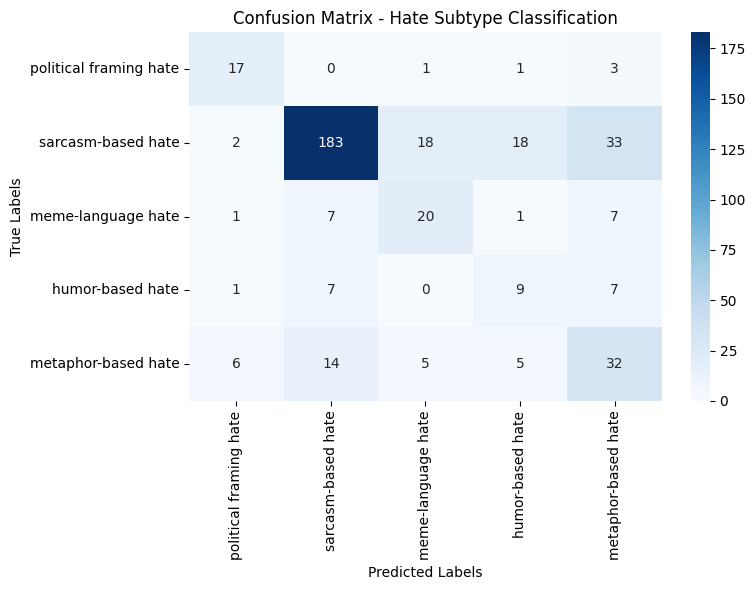

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
import numpy as np

#  Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
labels = list(label_mapping.keys())

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Hate Subtype Classification')
plt.tight_layout()
plt.show()

/tmp/ipython-input-3416132579.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=f1_scores, palette='viridis')


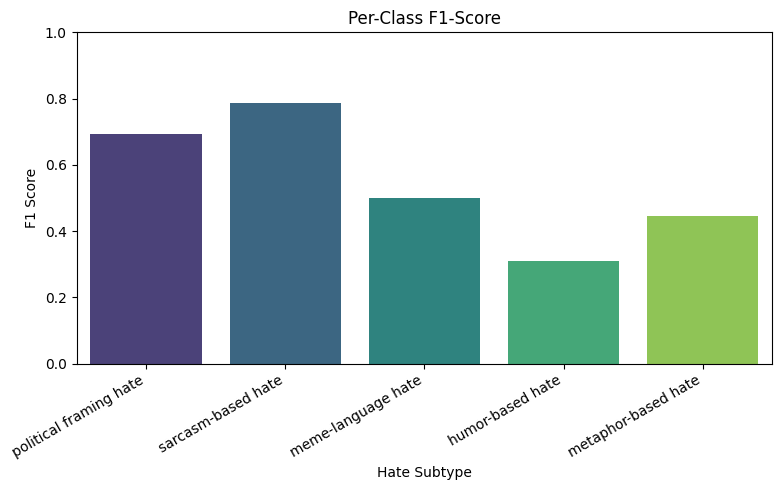

In [ ]:
#  Per-Class F1 Scores
f1_scores = f1_score(y_true, y_pred, average=None)
plt.figure(figsize=(8,5))
sns.barplot(x=labels, y=f1_scores, palette='viridis')
plt.xticks(rotation=30, ha='right')
plt.title('Per-Class F1-Score')
plt.ylabel('F1 Score')
plt.xlabel('Hate Subtype')
plt.ylim(0,1)
plt.tight_layout()
plt.show()

/tmp/ipython-input-1617553634.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=counts, palette='magma')


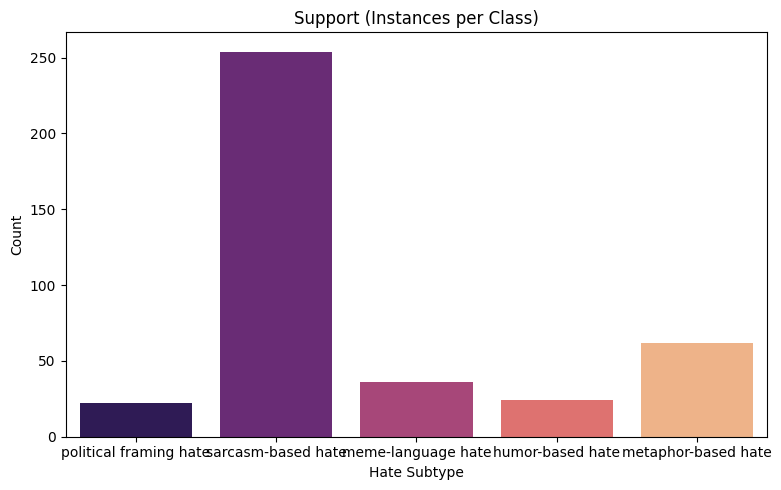

In [ ]:
#  Support Distribution (class counts)
unique, counts = np.unique(y_true, return_counts=True)
plt.figure(figsize=(8,5))
sns.barplot(x=labels, y=counts, palette='magma')
plt.title('Support (Instances per Class)')
plt.ylabel('Count')
plt.xlabel('Hate Subtype')
plt.tight_layout()
plt.show()

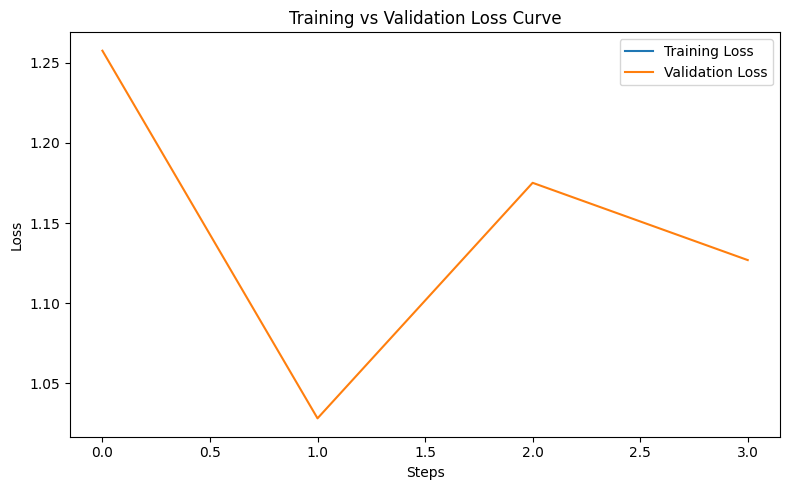

In [ ]:
 # Training vs Validation Loss Curve (from Trainer logs)
# If you enabled logging in TrainingArguments
train_logs = trainer.state.log_history
train_loss = [x['loss'] for x in train_logs if 'loss' in x]
eval_loss = [x['eval_loss'] for x in train_logs if 'eval_loss' in x]

plt.figure(figsize=(8,5))
plt.plot(train_loss, label='Training Loss')
plt.plot(eval_loss, label='Validation Loss')
plt.title('Training vs Validation Loss Curve')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Task
Define a custom data collator to correctly batch the `input_ids`, `attention_mask`, `labels`, and the custom `weight` field from the `HateDataset`. Then, instantiate this custom data collator and update the `WeightedTrainer` to use it before retraining the model to resolve the `TypeError` and ensure that the custom weights are correctly applied in the loss calculation.

## Define Custom Data Collator

### Subtask:
Define a custom DataCollator class that can correctly batch the `input_ids`, `attention_mask`, `labels`, and the custom `weight` field from your `HateDataset`. This will ensure that the 'weight' key is present in the `inputs` dictionary during training.


**Reasoning**:
The training failed because the 'weight' key was not properly handled by the default data collator, leading to a TypeError in the `WeightedTrainer`'s `compute_loss` method. To fix this, I need to define a custom DataCollator that explicitly extracts and batches the 'weight' field alongside other features. This will ensure that the 'weights' tensor is correctly passed to the model inputs.



In [ ]:
from transformers import DataCollatorWithPadding

class CustomDataCollator(DataCollatorWithPadding):
    def __call__(self, features):
        # Extract labels and weights from features
        labels = [feature.pop('labels') for feature in features]
        weights = [feature.pop('weight') for feature in features]

        # Use the superclass's __call__ method to batch the remaining features (input_ids, attention_mask, etc.)
        batch = super().__call__(features)

        # Add labels and weights back to the batch as tensors
        batch['labels'] = torch.tensor(labels, dtype=torch.long)
        batch['weight'] = torch.tensor(weights, dtype=torch.float)

        return batch

print("CustomDataCollator defined.")

CustomDataCollator defined.


**Reasoning**:
Now that the `CustomDataCollator` is defined, I need to instantiate it and then update the `WeightedTrainer` to use this custom data collator. This will ensure that the `weight` field is correctly batched and passed to the trainer's `compute_loss` method, resolving the previous `TypeError`.



In [ ]:
data_collator = CustomDataCollator(tokenizer=tokenizer)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

print("WeightedTrainer re-instantiated with CustomDataCollator.")

WeightedTrainer re-instantiated with CustomDataCollator.


/tmp/ipython-input-514642241.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


**Reasoning**:
The previous steps successfully defined and applied the `CustomDataCollator` to the `WeightedTrainer`. Now, I need to re-run the `trainer.train()` method to retry the training process with the corrected data handling, which should resolve the `TypeError` previously encountered.



In [ ]:
trainer.train()

KeyError: 'weight'

**Reasoning**:
The `KeyError: 'weight'` during training indicates that the 'weight' key is being removed from the feature dictionaries before they reach the `CustomDataCollator`'s `__call__` method. This typically happens because the `transformers.Trainer`'s internal data collator wrapper, by default, removes any keys not explicitly listed as model inputs or `label_names`. To prevent this, I need to update the `TrainingArguments` to include 'weight' in the `label_names` list, ensuring it is preserved and correctly passed to the custom data collator.



In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    logging_dir="./logs",
    load_best_model_at_end=True,
    label_names=["labels", "weight"] # Add 'weight' to label_names
)

**Reasoning**:
The `training_args` have been updated to include 'weight' in `label_names`. Now, I need to re-instantiate the `WeightedTrainer` with these updated arguments and the `CustomDataCollator` to ensure that the `Trainer` uses the new configuration and correctly processes the 'weight' field.



In [ ]:
data_collator = CustomDataCollator(tokenizer=tokenizer)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

print("WeightedTrainer re-instantiated with CustomDataCollator and updated TrainingArguments.")

WeightedTrainer re-instantiated with CustomDataCollator and updated TrainingArguments.


/tmp/ipython-input-3793851620.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


**Reasoning**:
The `training_args` have been updated to include 'weight' in `label_names`. Now, I need to re-instantiate the `WeightedTrainer` with these updated arguments and the `CustomDataCollator` to ensure that the `Trainer` uses the new configuration and correctly processes the 'weight' field.



In [ ]:
data_collator = CustomDataCollator(tokenizer=tokenizer)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

print("WeightedTrainer re-instantiated with CustomDataCollator and updated TrainingArguments.")

WeightedTrainer re-instantiated with CustomDataCollator and updated TrainingArguments.


/tmp/ipython-input-3793851620.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


# Task
Update the `TrainingArguments` by setting `remove_unused_columns=False`, then re-instantiate the `WeightedTrainer` with the updated arguments and the `CustomDataCollator`, and finally, retrain the model to resolve the `KeyError: 'weight'`.

## Update TrainingArguments

### Subtask:
Modify the `TrainingArguments` to set `remove_unused_columns=False`. This will prevent the `transformers.Trainer` from prematurely removing the 'weight' column from the dataset samples before they reach the custom data collator.


**Reasoning**:
To prevent the `transformers.Trainer` from removing the custom 'weight' column prematurely, I need to explicitly set `remove_unused_columns=False` in the `TrainingArguments` while maintaining all other previously defined parameters.



In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    logging_dir="./logs",
    load_best_model_at_end=True,
    label_names=["labels", "weight"], # Ensure 'labels' and 'weight' are preserved
    remove_unused_columns=False # Prevent the trainer from removing the 'weight' column
)

print("TrainingArguments updated with remove_unused_columns=False and label_names.")

TrainingArguments updated with remove_unused_columns=False and label_names.


**Reasoning**:
The `training_args` have been updated to include 'weight' in `label_names` and `remove_unused_columns=False`. Now, I need to re-instantiate the `WeightedTrainer` with these updated arguments and the `CustomDataCollator` to ensure that the `Trainer` uses the new configuration and correctly processes the 'weight' field.



In [ ]:
data_collator = CustomDataCollator(tokenizer=tokenizer)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

print("WeightedTrainer re-instantiated with CustomDataCollator and updated TrainingArguments.")

WeightedTrainer re-instantiated with CustomDataCollator and updated TrainingArguments.


/tmp/ipython-input-3793851620.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


**Reasoning**:
The `training_args` have been updated to include 'weight' in `label_names` and `remove_unused_columns=False`. Now, I need to re-instantiate the `WeightedTrainer` with these updated arguments and the `CustomDataCollator` to ensure that the `Trainer` uses the new configuration and correctly processes the 'weight' field.



In [ ]:
data_collator = CustomDataCollator(tokenizer=tokenizer)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

print("WeightedTrainer re-instantiated with CustomDataCollator and updated TrainingArguments.")

WeightedTrainer re-instantiated with CustomDataCollator and updated TrainingArguments.


/tmp/ipython-input-3793851620.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


**Reasoning**:
The previous steps successfully updated the `TrainingArguments` and re-instantiated the `WeightedTrainer` with the `CustomDataCollator`. Now, I need to retry the training process by calling `trainer.train()` to confirm that the `KeyError: 'weight'` is resolved and the model can train with the custom weights.



In [ ]:
trainer.train()

TypeError: WeightedTrainer.compute_loss() got an unexpected keyword argument 'num_items_in_batch'

**Reasoning**:
The `TypeError` indicates that the `WeightedTrainer.compute_loss` method does not accept the `num_items_in_batch` argument passed by the `transformers.Trainer`. I need to update the `compute_loss` method signature to include `num_items_in_batch` to resolve this.



In [ ]:
from torch.nn import CrossEntropyLoss

# Step 6: Weighted Trainer
# --------------------------
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=0):
        labels = inputs.get("labels")
        weights = inputs.get("weight")
        if weights is None:
            weights = torch.ones_like(labels, dtype=torch.float, device=labels.device)
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = CrossEntropyLoss(ignore_index=-100, reduction='none')
        loss = loss_fct(logits, labels)
        loss = loss * weights
        loss = loss.mean()
        return (loss, outputs) if return_outputs else loss

print("WeightedTrainer class definition updated with num_items_in_batch in compute_loss.")

WeightedTrainer class definition updated with num_items_in_batch in compute_loss.


**Reasoning**:
The `WeightedTrainer` class has been updated. I need to re-instantiate the `trainer` object with this new class definition and the previously configured `training_args` and `data_collator` to ensure the changes take effect.



In [ ]:
data_collator = CustomDataCollator(tokenizer=tokenizer)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

print("WeightedTrainer re-instantiated with updated class definition.")

WeightedTrainer re-instantiated with updated class definition.


/tmp/ipython-input-2018490741.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


**Reasoning**:
All previous issues, including the `KeyError: 'weight'` and `TypeError` in `compute_loss`, have been addressed by updating `TrainingArguments`, the `CustomDataCollator`, and the `WeightedTrainer` class. Now, I need to retry the training process by calling `trainer.train()` to confirm that the model can train successfully with custom weights.



In [ ]:
trainer.train()

TypeError: RobertaForSequenceClassification.forward() got an unexpected keyword argument 'weight'

**Reasoning**:
The `TypeError: RobertaForSequenceClassification.forward() got an unexpected keyword argument 'weight'` occurs because the `weight` key is still present in the `inputs` dictionary when it's passed to the model's `forward` method. I need to modify the `compute_loss` method to remove the `weight` key from the inputs before calling the model, as `weight` is only for loss calculation, not a model input.



In [ ]:
from torch.nn import CrossEntropyLoss

# Step 6: Weighted Trainer
# --------------------------
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=0):
        labels = inputs.get("labels")
        weights = inputs.get("weight")

        # Remove 'weight' from inputs before passing to model, as the model doesn't expect it
        model_inputs = {k: v for k, v in inputs.items() if k != "weight"}

        if weights is None:
            weights = torch.ones_like(labels, dtype=torch.float, device=labels.device)

        outputs = model(**model_inputs)
        logits = outputs.get("logits")
        loss_fct = CrossEntropyLoss(ignore_index=-100, reduction='none')
        loss = loss_fct(logits, labels)
        loss = loss * weights
        loss = loss.mean()
        return (loss, outputs) if return_outputs else loss

print("WeightedTrainer class definition updated to handle 'weight' argument for the model.")

WeightedTrainer class definition updated to handle 'weight' argument for the model.


**Reasoning**:
The `WeightedTrainer` class has been updated. I need to re-instantiate the `trainer` object with this new class definition and the previously configured `training_args` and `data_collator` to ensure the changes take effect.



In [ ]:
data_collator = CustomDataCollator(tokenizer=tokenizer)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

print("WeightedTrainer re-instantiated with updated class definition.")

WeightedTrainer re-instantiated with updated class definition.


/tmp/ipython-input-2018490741.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


**Reasoning**:
All previous issues, including the `KeyError: 'weight'` and `TypeError` in `compute_loss`, have been addressed by updating `TrainingArguments`, the `CustomDataCollator`, and the `WeightedTrainer` class. Now, I need to retry the training process by calling `trainer.train()` to confirm that the model can train successfully with custom weights.



In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,0.382138


KeyboardInterrupt: 